In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

In [2]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
image_path = '../data'
mnist_dataset = torchvision.datasets.MNIST(image_path, download=False)

In [7]:
import random
shuffled_indices = list(range(60000))
random.shuffle(shuffled_indices)
train_indices = shuffled_indices[:50000]
valid_indices = shuffled_indices[50000:]

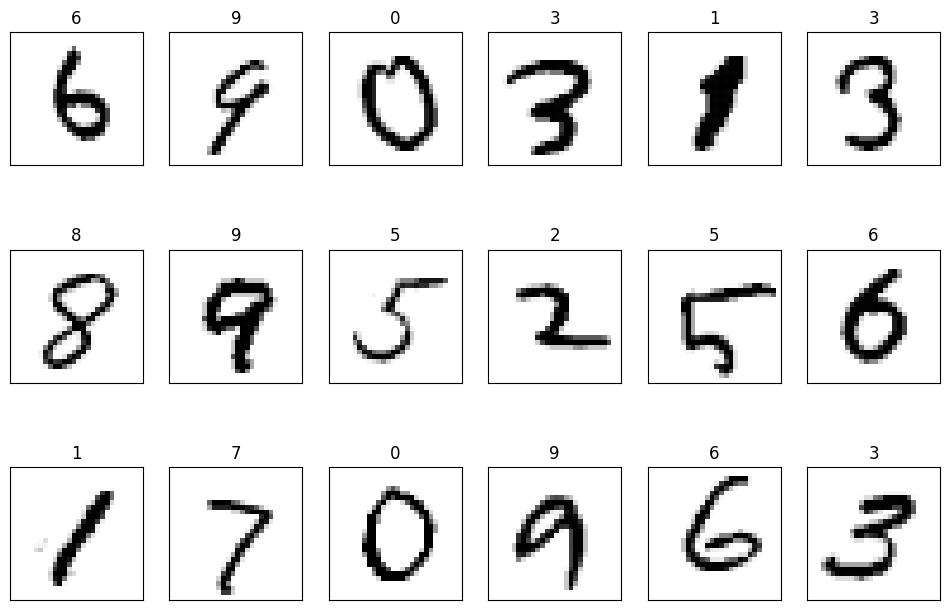

In [18]:
fig = plt.figure(figsize=(12, 8))
for i, index in enumerate(train_indices[:18]):
    image, label = mnist_dataset[index]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(image, cmap='Greys')
    ax.set_title(label)
    ax.set_xticks([]); ax.set_yticks([])

plt.show()

In [24]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, source_dataset, transform=None, target_transform=None):
        super(ImageDataset, self).__init__()
        self.source_dataset = source_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, lbl = self.source_dataset[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            lbl = self.target_transform(lbl)
        return img, lbl
    
    def __len__(self):
        return len(self.source_dataset)

In [78]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def target_transform(y):
    return torch.tensor([1 if i==y else 0 for i in range(10)], dtype=torch.float)

In [79]:
from torch.utils.data import Subset
raw_train_set = Subset(mnist_dataset, train_indices)
raw_valid_set = Subset(mnist_dataset, valid_indices)

train_set = ImageDataset(raw_train_set, transform, target_transform)
valid_set = ImageDataset(raw_valid_set, transform, target_transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=64, num_workers=4)

In [80]:
images, labels = next(iter(valid_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

In [ ]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def eval(self, data_loader, loss_fn, device=None):
        with torch.no_grad():
            loss = accuracy = 0
            for X, y in data_loader:
                if device:
                    X = X.to(device)
                    y = y.to(device)

                pred = self(X)

                loss += loss_fn(pred, y) * y.size(0)
                is_correct = (torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).float()
                accuracy += is_correct.sum().item()

        return loss / len(data_loader.dataset), accuracy / len(data_loader.dataset)

    
    def train(self, train_loader, epochs, loss_fn, optimizer, valid_loader=None, device=None):
        for epoch in range(epochs):
            for X, y in train_loader:
                if device:
                    X = X.to(device)
                    y = y.to(device)
                pred = self(X)
                loss = loss_fn(pred, y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        
            loss, accuracy = self.eval(train_loader, loss_fn, device)
            print(f'Epoch {epoch}, Train loss: {loss}, Train accuracy: {accuracy}')
            if valid_loader:
                loss, accuracy = self.eval(valid_loader, loss_fn, device)
                print(f'Valid loss: {loss}, Valid accuracy: {accuracy}')

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

In [105]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
epochs = 10
model.train(train_loader, epochs, loss_fn, optimizer, valid_loader=valid_loader, device=device)

Epoch 0, Train loss: 0.07883478701114655, Train accuracy: 0.97762
Valid loss: 0.10839752852916718, Valid accuracy: 0.9685
Epoch 1, Train loss: 0.0857531875371933, Train accuracy: 0.974
Valid loss: 0.11685643345117569, Valid accuracy: 0.9645
Epoch 2, Train loss: 0.07086119800806046, Train accuracy: 0.97948
Valid loss: 0.10274798423051834, Valid accuracy: 0.9686
Epoch 3, Train loss: 0.06448142230510712, Train accuracy: 0.9817
Valid loss: 0.0989360436797142, Valid accuracy: 0.9703
Epoch 4, Train loss: 0.061417680233716965, Train accuracy: 0.98286
Valid loss: 0.09881275147199631, Valid accuracy: 0.97
Epoch 5, Train loss: 0.05836070328950882, Train accuracy: 0.98396
Valid loss: 0.09404060244560242, Valid accuracy: 0.9716
Epoch 6, Train loss: 0.05135520547628403, Train accuracy: 0.98552
Valid loss: 0.0904030054807663, Valid accuracy: 0.9729
Epoch 7, Train loss: 0.04987391456961632, Train accuracy: 0.98586
Valid loss: 0.09024062007665634, Valid accuracy: 0.9727
Epoch 8, Train loss: 0.04698206

In [121]:
def predict(i):
    X = transform(mnist_dataset[i][0])
    pred = model(X.reshape(1, -1).to(device))
    pred = pred.argmax(dim=1).item()
    return pred

In [122]:
wrong = []
for i in valid_indices:
    X = transform(mnist_dataset[i][0])
    pred = model(X.reshape(1, -1).to(device))
    pred = pred.argmax(dim=1).item()
    if pred != mnist_dataset[i][1]:
        wrong.append((i, pred))
len(wrong)

269

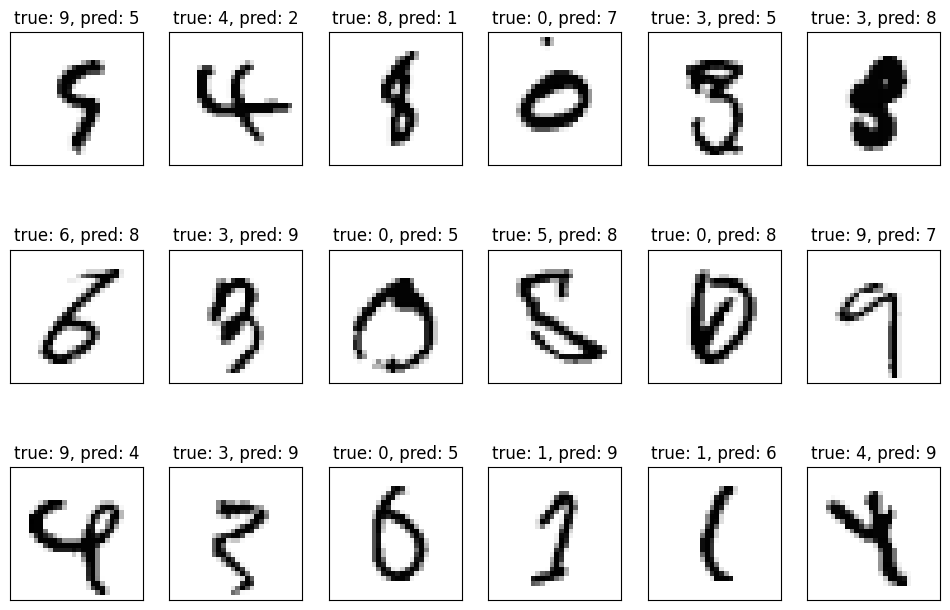

In [127]:
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(mnist_dataset[wrong[i][0]][0], cmap='Greys')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'true: {mnist_dataset[wrong[i][0]][1]}, pred: {wrong[i][1]}')
plt.show()